In [1]:
import torch
from torch import nn, optim
import mltools

In [2]:
class LSTMMNISTModel(nn.Module):
    '''循环神经网络分类模型'''

    def __init__(self, *args, **kwargs):
        '''初始化函数'''
        nn.Module.__init__(self, *args, **kwargs)
        self.hidden_layer = nn.LSTM(input_size=28 * 1, hidden_size=512, batch_first=True, bidirectional=True)  # 定义隐藏层
        self.output_layer = nn.Linear(512 * 2, 10)  # 定义输出层

    def forward(self, x, state=None):
        '''前向传播'''
        x, state = self.hidden_layer(x, state)  # x形状为(批量大小, 时间步数, 隐藏大小), state形状为(隐藏层数 * directions, 批量大小, 隐藏大小)
        x = x.mean(dim=1)  # 在时间步数维度取平均, x形状为(批量大小, 隐藏大小)
        x = self.output_layer(x)  # 它的输出形状是(批量大小, 输出大小)
        return x, state

In [3]:
class LSTMMNIST(mltools.MachineLearning):
    '''RNN 图片分类学习'''

    @mltools.MachineLearning.trainer
    def train(self, num_epochs):
        '''迭代训练'''
        for _ in range(1, num_epochs + 1):
            self.timer.start()

            # 计算训练集
            metric_train = mltools.Accumulator(2)  # 累加器：(train_loss, train_size)
            self.model.train()  # 训练模式
            for x, y in self.train_iter:
                x = x.to(self.device)  # 转换x
                x = x.permute(0, 2, 1, 3)  # 交换图片通道数和图片高度的维度, x形状为(批量大小, 图片高度, 图片通道数, 图片宽度)
                x = x.reshape(x.shape[0], x.shape[1], -1)  # 将图片展平, x形状为(批量大小, 图片高度, 图片通道数 * 图片宽度)
                y = y.to(self.device)  # 转换y
                y_train, _ = self.model(x)  # 计算模型
                train_loss = self.loss(y_train, y)  # 计算训练损失

                # 梯度更新
                self.optimizer.zero_grad()
                train_loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
                self.optimizer.step()

                metric_train.add(train_loss * y.numel(), y.numel())
            self.recorder[0].append(metric_train[0] / metric_train[1])

            self.timer.stop()

            # 计算验证集
            metric_val = mltools.Accumulator(3)  # 累加器：(val_loss, val_acc, val_size)
            self.model.eval()  # 验证模式
            with torch.no_grad():
                for x, y in self.val_iter:
                    x = x.to(self.device)  # 转换x
                    x = x.permute(0, 2, 1, 3)  # 交换图片通道数和图片高度的维度, x形状为(批量大小, 图片高度, 图片通道数, 图片宽度)
                    x = x.reshape(x.shape[0], x.shape[1], -1)  # 将图片展平, x形状为(批量大小, 图片高度, 图片通道数 * 图片宽度)
                    y = y.to(self.device)  # 转换y
                    y_val, _ = self.model(x)  # 计算模型
                    val_loss = self.loss(y_val, y)  # 计算验证损失
                    val_pred = y_val.argmax(dim=1)  # 计算预测值
                    val_acc = (val_pred == y).sum()  # 计算验证准确率
                    metric_val.add(val_loss * y.numel(), val_acc, y.numel())
            self.recorder[1].append(metric_val[0] / metric_val[2])
            self.recorder[2].append(metric_val[1] / metric_val[2])

            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')
            self.animator.show(self.recorder.data)  # 添加损失值
        else:
            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')

    @mltools.MachineLearning.tester
    def test(self):
        '''测试模型'''
        metric = mltools.Accumulator(2)  # 累加器：(test_acc, test_size)
        with torch.no_grad():
            for x, y in self.test_iter:
                x = x.to(self.device)  # 转换x
                x = x.permute(0, 2, 1, 3)  # 交换图片通道数和图片高度的维度, x形状为(批量大小, 图片高度, 图片通道数, 图片宽度)
                x = x.reshape(x.shape[0], x.shape[1], -1)  # 将图片展平, x形状为(批量大小, 图片高度, 图片通道数 * 图片宽度)
                y = y.to(self.device)  # 转换y
                y_test, _ = self.model(x)  # 计算模型
                test_pred = y_test.argmax(dim=1)  # 计算准确率
                test_acc = (test_pred == y).sum()  # 计算测试准确率
                metric.add(test_acc, y.numel())
        self.logger.info(f'test acc {metric[0] / metric[1]:.3f}')  # 计算测试准确率并输出

    @mltools.MachineLearning.predictor
    def predict(self):
        '''预测模型'''
        x, y = next(iter(self.test_iter))  # 从测试中取一个批量
        x = x[:10].to(self.device)
        x = x.permute(0, 2, 1, 3)  # 交换图片通道数和图片高度的维度, x形状为(批量大小, 图片高度, 图片通道数, 图片宽度)
        x = x.reshape(x.shape[0], x.shape[1], -1)  # 将图片展平, x形状为(批量大小, 图片高度, 图片通道数 * 图片宽度)
        y = y[:10].to(self.device)
        y_pred, _ = self.model(x)  # 计算模型
        y_pred = y_pred.argmax(dim=1)  # 计算预测
        labels = [f'real:{y[index]}\npred:{y_pred[index]}' for index in range(y.numel())]
        mltools.images(x.squeeze(1), labels, shape=(2, 5))

In [ ]:
train_iter, val_iter, test_iter = mltools.mnist('../data', batch_size=1000)  # 获取训练集、验证集和测试集
model = LSTMMNISTModel()  # 定义训练模型
loss = nn.CrossEntropyLoss()  # 设置损失函数
optimizer = optim.SGD(model.parameters(), lr=1e-1)  # 设置优化器
legend = ['train loss', 'val loss', 'val acc']  # 设置图例
device = torch.device('cuda')  # 设置设备
ml = LSTMMNIST(train_iter, val_iter, test_iter, model=model, loss=loss, optimizer=optimizer, legend=legend, device=device)

2025-05-24 15:29:01,336 - INFO: train loss 0.122, val loss 0.116, val acc 0.963, 18.4 sec/epoch on cuda


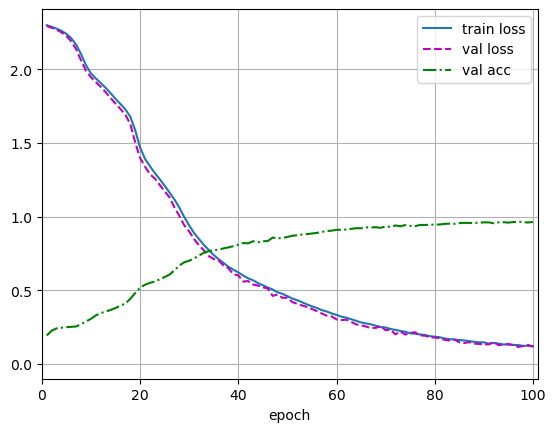

In [5]:
ml.train(num_epochs=100)  # 训练

In [6]:
ml.test()  # 测试

2025-05-24 15:29:02,982 - INFO: test acc 0.967


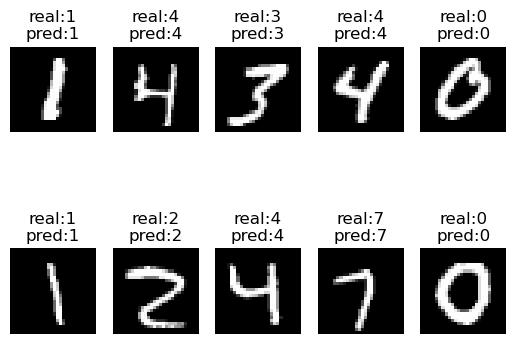

In [7]:
ml.predict()  # 预测